### 并行版本+joblib

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
from joblib import Parallel, delayed
# 自定义函数
from import_fun import HH, syn_sigmoidal, syn_sigmoidal_delay, create_sf, delayer, synFactor

In [ ]:
def net(N, method, dt, conn, tau):
    delayN = int(tau/dt)

    nodes = HH(N, method, dt)
    nodes.params_nodes["Iex"] = 20.
    syn = syn_sigmoidal_delay(nodes, nodes, conn, method=method, delayN=delayN)
    syn.w.fill(0.1)

    for i in range(100_00):
        nodes()

    for i in range(500_00):
        Isyn = syn()
        nodes(Isyn)

    cal_Tn = 2000_00
    synFer = synFactor(N, cal_Tn)
    nodes.record_spike_times = True
    for i in range(cal_Tn):
        Isyn = syn()
        nodes(Isyn)
        synFer(nodes.vars_nodes[0])
        
    SFactor = synFer.return_syn()
    kop = nodes.cal_kop()[0]

    return SFactor, kop

In [20]:
dt = 0.01
method = "euler"   # （"euler", "rk4"）
N = 100
conn = create_sf(n=N, n_init=5, n_add=2)
tau_list = np.arange(0.01, 30, .5)

In [21]:
n = len(tau_list)
SFactors = np.zeros(n)
kops = np.zeros(n) 

results = Parallel(n_jobs=-1, backend='loky')(
    delayed(net)(N, method, dt, conn, tau) for tau in tau_list
)

SFactors, kops = map(np.array, zip(*results))
    

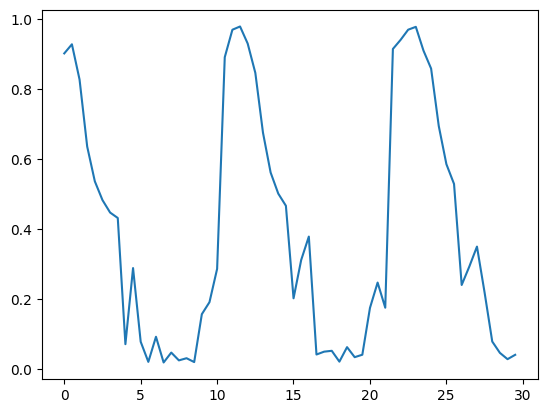

In [22]:
plt.plot(tau_list, SFactors)
plt.show()

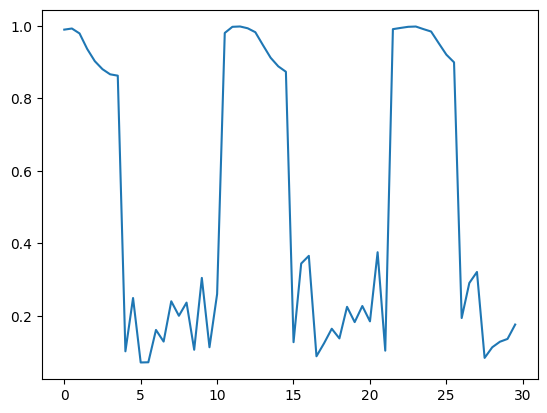

In [23]:
plt.plot(tau_list, kops)
plt.show()

In [24]:
# plt.plot(time, mem)
# plt.show()